In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()
# cuda.select_device(0)

**importing libraries**

In [1]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
import json
import tensorflow_hub as hub
from tensorflow.keras.applications import efficientnet
from transformers import AutoTokenizer, AutoModelForMaskedLM
from tensorflow.keras.applications.inception_v3 import InceptionV3
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**Importing COCO dataset**

In [2]:
BASE_PATH = '/kaggle/input/coco-2017-dataset/coco2017'

In [3]:
with open(f'{BASE_PATH}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}/train2017/{x}'
)
captions = captions.sample(70000)
captions = captions.reset_index(drop=True)
captions.size

140000

**Preprocessing prompts in dataset**

In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [5]:
captions['caption'] = captions['caption'].apply(preprocess)

In [6]:
random_row = captions.sample(1).iloc[0]

**Assigning parameters**

In [7]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 12000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512
EPOCHS = 5

**Getting tokenizer from Keras**

In [9]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

In [10]:
tokenizer.vocabulary_size()

11879

In [11]:
import pickle

pickle.dump(tokenizer.get_vocabulary(), open('vocab_coco.file', 'wb'))

In [12]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

**Preparing training and validation sets**

In [13]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index], 
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [14]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(56018, 56018, 13982, 13982)

In [15]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    caption = tokenizer(caption)
    return img, caption

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [17]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

**Utilising InceptionV3 Encoder**

In [18]:
def CNN_Encoder():
    inception_v3 = InceptionV3(weights='/kaggle/input/weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model


**Tansformer Encoder Layer**

In [19]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

**Embeddings for transformer**

In [20]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))
    

    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

**Transformer Decoder Layer**

In [21]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
    

    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None
        
        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

**Defining structure to Image captioning model**

In [22]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)
    

    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc

    
    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)
        
        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )
    
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

**Defining caption_model**

In [23]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)


caption_model = ImageCaptioningModel(
    cnn_model=CNN_Encoder(), encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [24]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

**Training the model**

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=3)
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/5
1751/1751 [==============================] - 491s 277ms/step - loss: 3.0101 - acc: 0.4178 - val_loss: 3.2278 - val_acc: 0.4068
Epoch 2/5
1751/1751 [==============================] - 496s 280ms/step - loss: 2.9342 - acc: 0.4243 - val_loss: 3.2094 - val_acc: 0.4117
Epoch 3/5
1751/1751 [==============================] - 493s 278ms/step - loss: 2.8696 - acc: 0.4325 - val_loss: 3.1981 - val_acc: 0.4141
Epoch 4/5
1751/1751 [==============================] - 499s 281ms/step - loss: 2.8137 - acc: 0.4385 - val_loss: 3.1932 - val_acc: 0.4147
Epoch 5/5
1751/1751 [==============================] - 548s 309ms/step - loss: 2.7656 - acc: 0.4423 - val_loss: 3.1970 - val_acc: 0.4168


**Fucntion to generate caption from input images**

In [27]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)
    
    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))
    
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)
        
        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break
        
        y_inp += ' ' + pred_word
    
    y_inp = y_inp.replace('[start] ', '')
    return y_inp

**Load embedding model**

In [41]:
sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

In [42]:
st_model = SentenceTransformer('/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2')

**Example of predicting prompts**

Predicted Caption: a large clock tower with a clock on it



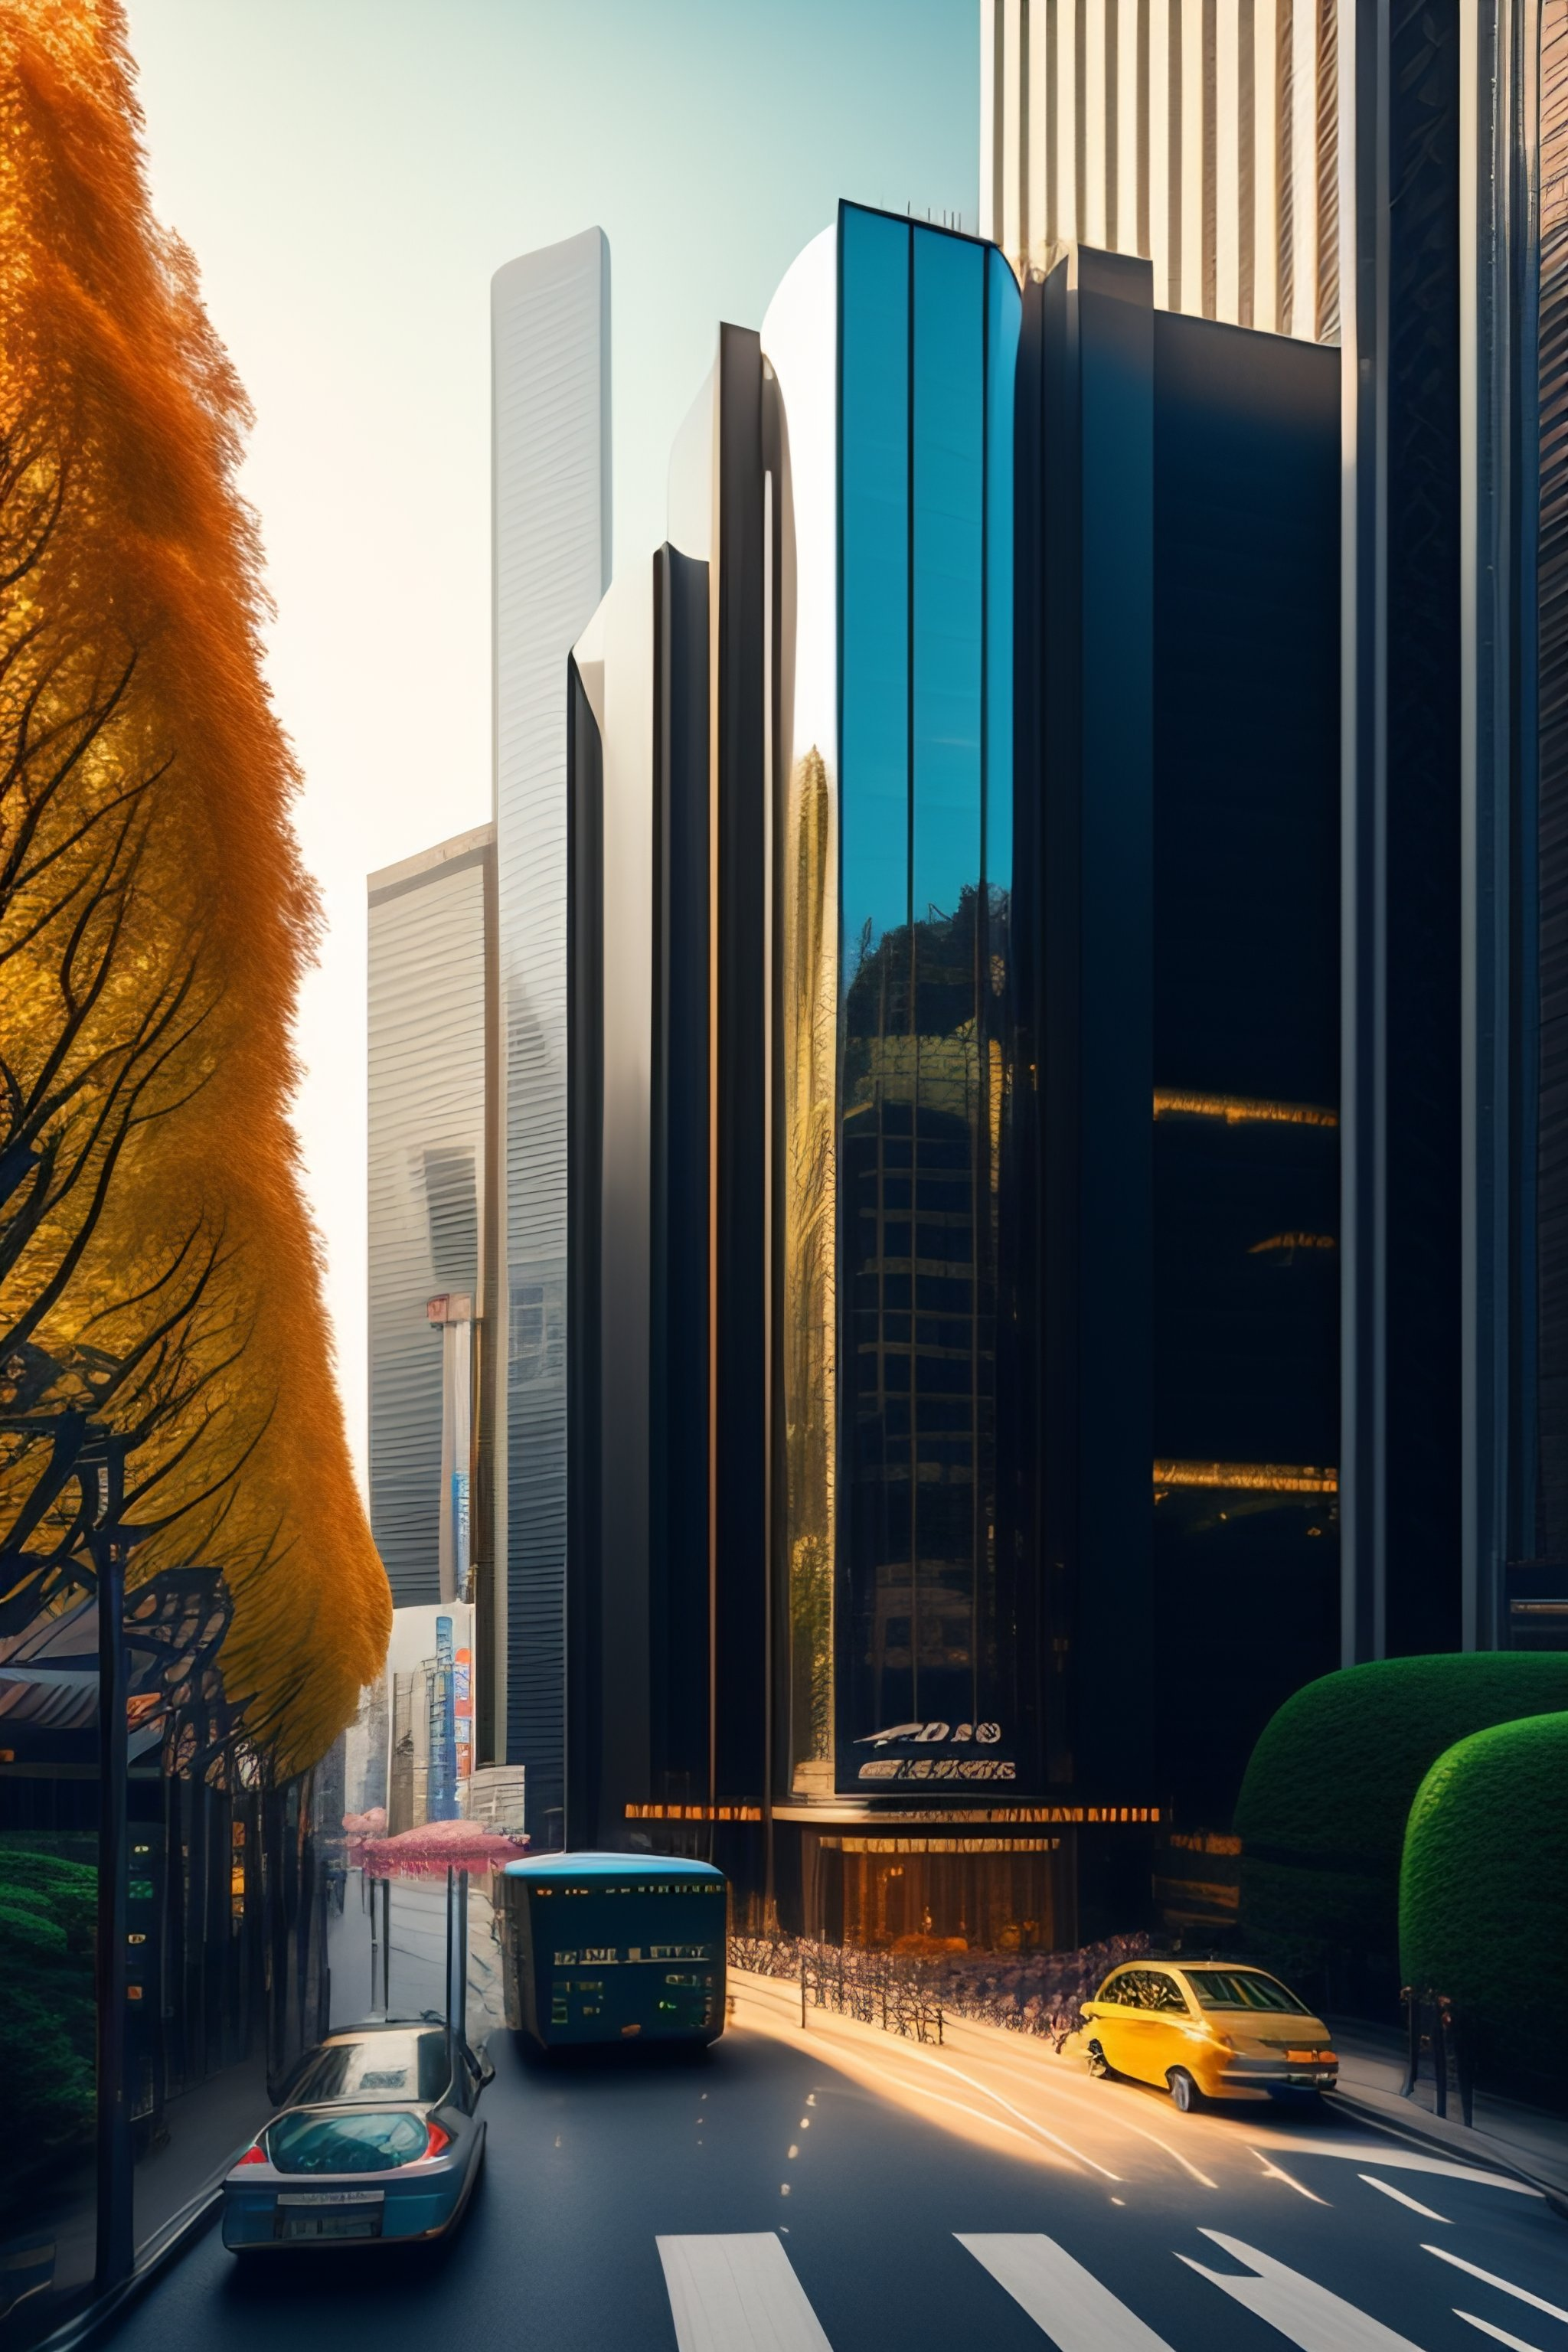

In [38]:
img_url = "https://image.lexica.art/full_jpg/0019eaf6-9326-415d-8988-7ece992078e2"

im = Image.open(requests.get(img_url, stream=True).raw)
im = im.convert('RGB')
im.save('tmp.jpg')

pred_caption = generate_caption('tmp.jpg', add_noise=False)
print('Predicted Caption:', pred_caption)
print()
im

**Convertins example prompt to embeddings**

In [ ]:
prompts = ['a large clock tower with a clock on it'] 
prompt_embeddings = st_model.encode(prompts).flatten()
prompt_embeddings